# Load data

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [22]:
df = pd.read_csv('ECE 143.csv')


In [23]:
df.set_index(["State"], inplace=True)

In [ ]:
['EV Sales\n2018','COMMUTE TIME','PUBLIC TRANSIT USAGE', 
        'ROAD QUALITY', 'BRIDGE QUALITY','Average retail price (cents/kWh)', 'Avg gasoline price per gallon','Advanced degree',
       'Median Household Income\t $', 'Charging Locations','Charging Outlets', 'Outlets Per Location', 'EV Stock','EVs to Charging Outlets']

In [132]:
print(subset.head())

   EV Sales\n2018  COMMUTE TIME  PUBLIC TRANSIT USAGE  ROAD QUALITY  \
0        0.005047      0.489796              0.857143      0.244898   
1        0.000411      0.142857              0.387755      0.693878   
2        0.045608      0.632653              0.408163      0.469388   
3        0.002237      0.183673              0.938776      0.714286   
4        1.000000      0.918367              0.163265      0.959184   

   BRIDGE QUALITY  Average retail price (cents/kWh)  \
0        0.428571                          0.100904   
1        0.714286                          0.595431   
2        0.061224                          0.133746   
3        0.326531                          0.024274   
4        0.367347                          0.436935   

   Avg gasoline price per gallon  Advanced degree  \
0                       0.000000            0.052   
1                       0.677419            0.104   
2                       0.314516            0.116   
3                       0.0322

In [38]:
df.columns

Index(['EV Sales\n2015', 'EV Sales\n2016', 'EV Sales\n2017', 'EV Sales\n2018',
       'EV Sales\n2015 % of Total', 'EV Sales\n2016 % of Total',
       'EV Sales\n2017 % of Total', 'EV Sales\n2018 % of Total',
       'Avg % of Total Sales 2015-2018', '2017 EV\nMarket Share\nW/in State',
       '2018 EV\nMarket Share\nW/in State', 'Avg/F', 'Avg/C', 'COMMUTE TIME',
       'PUBLIC TRANSIT USAGE', 'ROAD QUALITY', 'BRIDGE QUALITY',
       'Average retail price (cents/kWh)', 'Avg gasoline price per gallon',
       '% High school graduate\nor higher', '% Bachelor's degree\nor higher',
       'Advanced degree', 'Democratic Representation',
       'Republican Representation', '% Green Representation',
       '% Libertarian/ Independent Representation',
       'Median Household Income\t $',
       'Electric Vehicle Tax Credit Program (1/0)', 'Charging Locations',
       'Charging Outlets', 'Outlets Per Location', 'EV Stock',
       'EVs to Charging Outlets'],
      dtype='object')

In [5]:
sale_4years = df.iloc[:,0:4]
sale_4years['State'] = sale_4years.index.get_level_values('State')
x=pd.melt(sale_4years,id_vars="State", var_name="years", value_name="sale")
y=x.groupby(["State","years"]).sum()
y['State'] = y.index.get_level_values('State')
y['years'] = y.index.get_level_values('years')
y.head()

sale    State           years
State   years                                        
Alabama EV Sales\n2015   197  Alabama  EV Sales\n2015
        EV Sales\n2016   330  Alabama  EV Sales\n2016
        EV Sales\n2017   381  Alabama  EV Sales\n2017
        EV Sales\n2018   866  Alabama  EV Sales\n2018
Alaska  EV Sales\n2015    61   Alaska  EV Sales\n2015

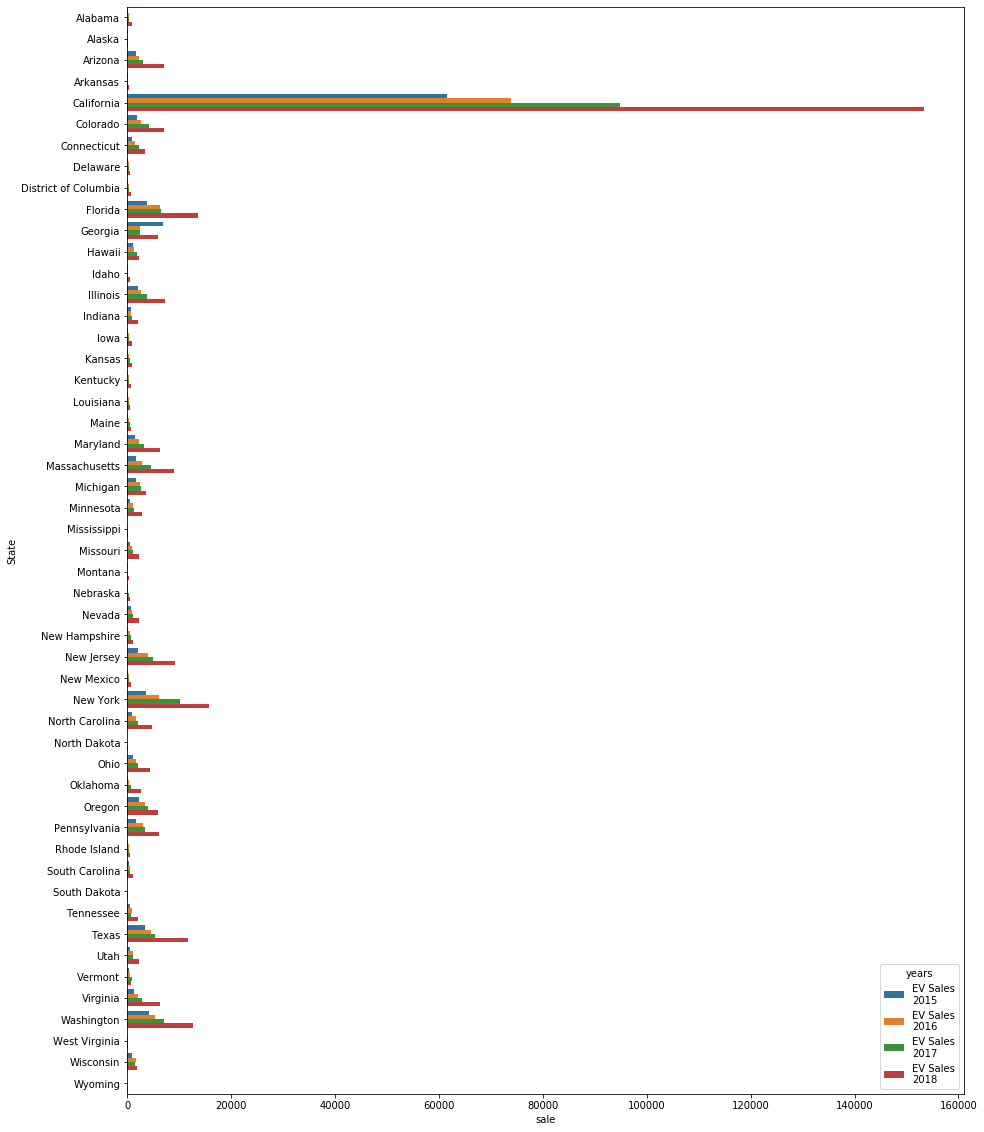

In [74]:
plt.figure(figsize=(15,20))
sns.barplot(x='State',y='sale' hue="years",data=y)

# Linear regression

In [75]:
from sklearn.linear_model import LinearRegression

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


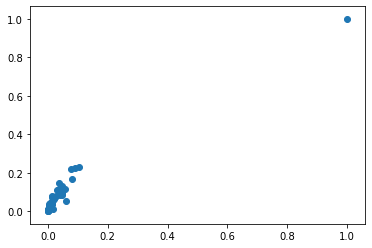

In [87]:
# pick 'charging locations' as an example
cla=df.iloc[:,[3,28]]

cla['Charging Locations'] = cla['Charging Locations'].astype(int)
# Data Normalization
cla=cla.apply(lambda x : (x-np.min(x))/(np.max(x)-np.min(x)))

plt.scatter(cla.iloc[:,0],cla.iloc[:,1])


In [81]:
cla.corr()

,EV Sales 2018,Charging Locations
EV Sales\n2018,1.000000,0.965633
Charging Locations,0.965633,1.000000


In [95]:

lrModel = LinearRegression()
x = cla.iloc[:,0]
y = cla.iloc[:,1]
x = np.array(x).reshape((len(x), 1))
y = np.array(y).reshape((len(y), 1))
lrModel.fit(x,y)
lrModel.score(x,y)



0.932447772814718

# Random forest 

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
dx = pd.read_csv('ECE 143.csv')
# dx=dx.iloc[:,[4,13,14,15,16,17]]
dx=dx.iloc[:,[4,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]]
dx.columns = ['EV Sales in 2018', 'Avg/C', 'COMMUTE TIME','PUBLIC TRANSIT USAGE','ROAD QUALITY','BRIDGE QUALITY','Average retail price','Avg gasoline price per gallon',
             'High school graduate or higher','Bachelors degree or higher','Advanced degree','Democratic Representation','Republican Representation',
             'Green Representation','Libertarian/ Independent Representation','Median Household Income','Tax Credit Program','Charging Locations',
             'Charging Outlets','Outlets Per Location','EV Stock','EVs to Charging Outlets']


x, y = dx.iloc[:, 1:].values, dx.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
np.nan_to_num(x_train)
np.nan_to_num(x_test)
np.nan_to_num(y_train)
np.nan_to_num(y_test)
feat_labels = dx.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(x_train, y_train)

KeyboardInterrupt: 

In [30]:
x, y = dx.iloc[:, 1:].values, dx.iloc[:, 0].values

In [45]:
dx.head(2)

,EV Sales in 2018,Avg/C,COMMUTE TIME,PUBLIC TRANSIT USAGE,ROAD QUALITY,BRIDGE QUALITY,Average retail price,Avg gasoline price per gallon,High school graduate or higher,Bachelors degree or higher,...,Republican Representation,Green Representation,Libertarian/ Independent Representation,Median Household Income,Tax Credit Program,Charging Locations,Charging Outlets,Outlets Per Location,EV Stock,EVs to Charging Outlets
0,866,17.1,25.0,43.0,13.0,22.0,9.83,2.54,0.853,0.245,...,0.621,0.0044,0.021,56200,0,115,268,2.33,2487,9.28
1,155,-3.0,8.0,20.0,35.0,36.0,20.22,3.38,0.924,0.290,...,0.513,0.0180,0.059,78394,0,16,26,1.62,534,20.54


importance： [0.05004513 0.05035401 0.04940376 0.05322673 0.05542079 0.05096607
 0.05292441 0.04830873 0.04980092 0.04929704 0.04807004 0.04843841
 0.04430483 0.04886285 0.04832332 0.01231763 0.04525903 0.04392398
 0.05599477 0.04368393 0.05107364]
 1) Outlets Per Location           0.055995
 2) BRIDGE QUALITY                 0.055421
 3) ROAD QUALITY                   0.053227
 4) Avg gasoline price per gallon  0.052924
 5) EVs to Charging Outlets        0.051074
 6) Average retail price           0.050966
 7) COMMUTE TIME                   0.050354
 8) Avg/C                          0.050045
 9) Bachelors degree or higher     0.049801
10) PUBLIC TRANSIT USAGE           0.049404
11) Advanced degree                0.049297
12) Libertarian/ Independent Representation 0.048863
13) Republican Representation      0.048438
14) Median Household Income        0.048323
15) High school graduate or higher 0.048309
16) Democratic Representation      0.048070
17) Charging Locations             0.04

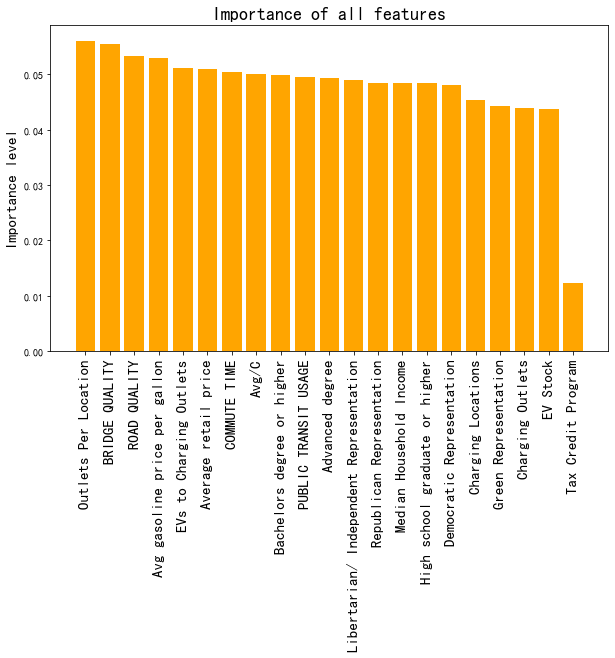

In [191]:
importances = forest.feature_importances_
print("importance：", importances)

x_columns = dx.columns[1:]
indices = np.argsort(importances)[::-1]
x_columns_indices = []
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    x_columns_indices.append(feat_labels[indices[f]])
plt.figure(figsize=(10, 6))
plt.title("Importance of all features", fontsize=18)
plt.ylabel("Importance level", fontsize=15, rotation=90)
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
for i in range(x_columns.shape[0]):
    plt.bar(i, importances[indices[i]], color='orange', align='center')
    plt.xticks(np.arange(x_columns.shape[0]), x_columns_indices, rotation=90, fontsize=15)
plt.show()

In [131]:
#df.corr()

In [117]:
numericalSubset = ['EV Sales\n2018','COMMUTE TIME','PUBLIC TRANSIT USAGE', 
        'ROAD QUALITY', 'BRIDGE QUALITY','Average retail price (cents/kWh)', 'Avg gasoline price per gallon','Advanced degree',
       'Median Household Income\t $', 'Charging Locations','Charging Outlets', 'Outlets Per Location', 'EV Stock','EVs to Charging Outlets']
subset = df[numericalSubset]

In [121]:
#normalize the data
x = subset.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
subset = pd.DataFrame(x_scaled,columns = numericalSubset)

/Users/akshayavagulabooshanam/miniconda3/envs/kaggleHealthAnalytics/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/akshayavagulabooshanam/miniconda3/envs/kaggleHealthAnalytics/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)


/Users/akshayavagulabooshanam/miniconda3/envs/kaggleHealthAnalytics/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


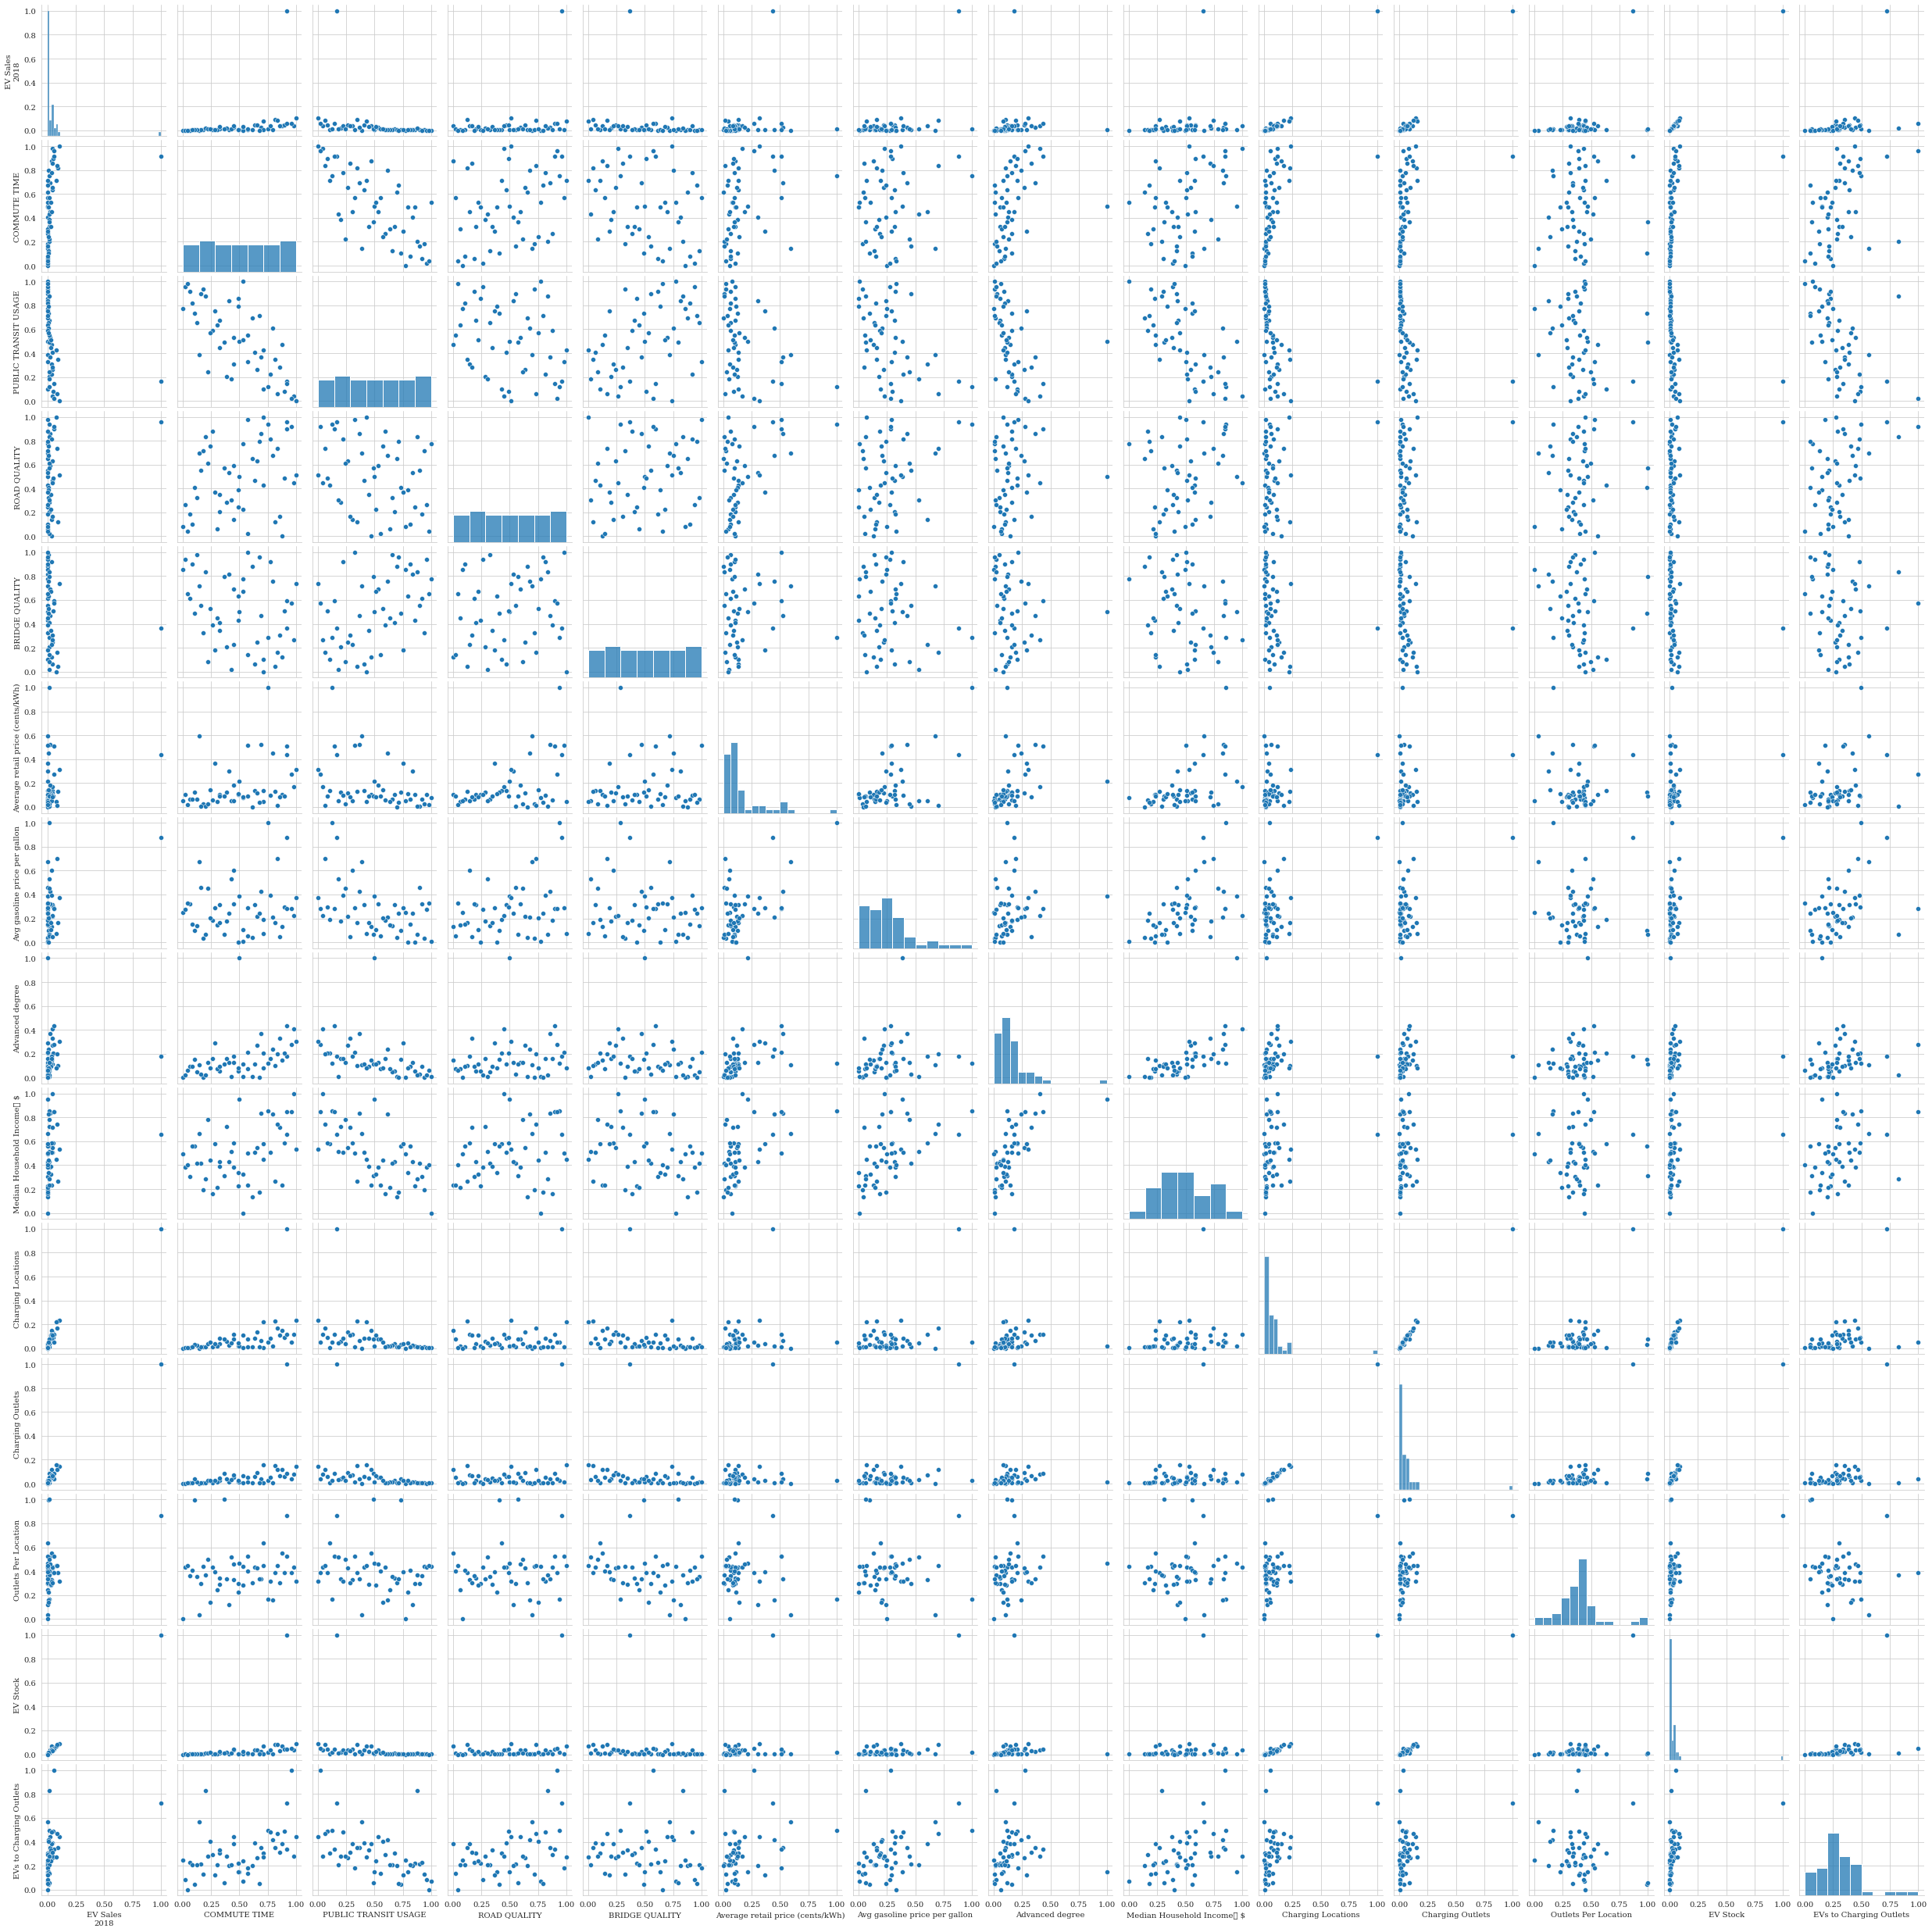

In [122]:
sns.pairplot(subset,vars = numericalSubset,diag_kind='hist')

The above plot shows the pairwise relationship between multiple independent variables in the plot but a couple of them have a strong collinearity with other variables. 

Principal component analysis of these variables can condense the information described by correlated variables as few principal components that explain much of the variance in the data

In [129]:
#do PCA to condense information

pca = PCA(n_components=8,svd_solver='full')
pca.fit(x_scaled)

PCA(n_components=8, svd_solver='full')

In [130]:
print(pca.explained_variance_ratio_)

[0.3858933  0.16638594 0.11482942 0.09317023 0.06828851 0.06009367
 0.03805057 0.0304611 ]


In [64]:
df["chargingLocations_binned"] = pd.qcut(df['Charging Locations'], q=6, precision = 0)

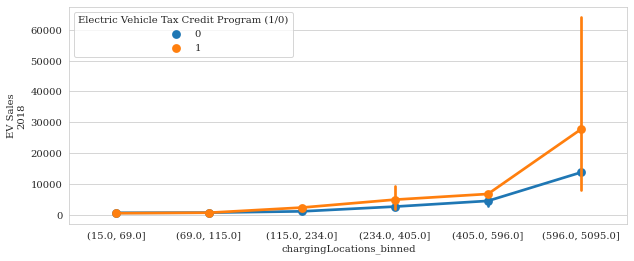

In [79]:
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.pointplot(x="chargingLocations_binned", y="EV Sales\n2018", hue="Electric Vehicle Tax Credit Program (1/0)", kind="point",ax = ax, data=df);

In [81]:
np.unique(df["ROAD QUALITY"])

array([ 1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. ,
       12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. ,
       23. , 24. , 25. , 25.5, 26. , 27. , 28. , 29. , 30. , 31. , 32. ,
       33. , 34. , 35. , 36. , 37. , 38. , 39. , 40. , 41. , 42. , 43. ,
       44. , 45. , 46. , 47. , 48. , 49. , 50. ])